# Experiments and Plotting 
-----------

A primary goal of our experiments is to compare the performance between a DQN model and an IQ-Learn model trained to solve a static gridworld problem. To do this, we fix as many shared parameters as possible. The key differences between our DQN model and IQ-Learn model lies in the source of the data and the loss function used to optimize the model. Critically, the DQN learns by randomly exploring the environment and training its policy online using information about current reward and the anticipated value of its next state. Instead, IQ-Learn trains offline on a buffer of expert data using current and next state values and current Q value, without any knowledge of environment rewards. 

In these experiments, we will first perform some pretests to: 
- determine an appropriate batch size to use for both models based on the best performance from the DQN
- determine the number of necessary expert trajectories to achieve good performance on a fixed gridworld. 

We then directly compare the training and testing performance between the models.

In [1]:
from experiments_functions import *

pygame 2.1.3 (SDL 2.0.22, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\celin\Documents\python_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# set some global experiment parameters
NUM_TIMESTEPS = 20000

#### Determine Appropriate Batch Size
To determine the appropriate batch size to use for our comparison, we trained a DQN using a range of batch sizes and selected batch_size={32 timesteps}, given its rapid loss decay and stable good performance after a relatively short number of training steps comapred to other batch sizes. While batch_size={64 timesteps} also demonstrated good performance, it did not result in a noticeable improvement after the 1000th training step.

In [ ]:
### compare batch sizes for DQN
batch_sizes = [4, 8, 32, 64]
losses, dist_rats = compare_param_range("DQN", "batch_size", batch_sizes, num_timesteps=NUM_TIMESTEPS)

plot_losses(losses, name="_"+"DQN"+"_" +"batch_size"+"_"+str(NUM_TIMESTEPS)+"_comparison")
plot_distance_ratios(dist_rats, name="_"+"DQN"+"_"+"batch_size"+"_"+str(NUM_TIMESTEPS)+"_comparison")

#### Determine sufficent expert trajectories to train IQLearn
Using a fixed batch_size of 32, we trained an IQLearn agent using different sized datasets of expert trajectories sources from the same expert to determine an appropriate number of expert trajectories for our model training comparison. 

In [ ]:
### compare num_trajectories for IQLearn
num_trajectories_list = [25, 50, 100, 300]
losses, dist_rats = compare_param_range("IQLearn", "num_trajectories", num_trajectories_list, num_timesteps=NUM_TIMESTEPS)

plot_losses(losses, name="_"+"IQLearn"+"_" +"num_trajectories"+"_"+str(NUM_TIMESTEPS)+"_comparison")
plot_distance_ratios(dist_rats, name="_"+"IQLearn"+"_"+"num_trajectories"+"_"+str(NUM_TIMESTEPS)+"_comparison")

Test DQN and IQ-Learn on static walls case
####

In [ ]:
NUM_TIMESTEPS = 8
TESTING_FREQ = 50
NUM_TEST_GAMES = 128
RANDOM_WALLS = True
FOLDER_PATH = "" # "data/IQLearn_rand_walls/"
AGENT_TYPE = "IQLearn"
# get DQN params and set them
params = get_agent_params(AGENT_TYPE)
params["expert_data_path"] = "expert_data/human_5000_random_walls.pkl"
# train the agent
losses, distance_ratios = train_agent(params=params,
            num_timesteps=NUM_TIMESTEPS, 
            random_walls=RANDOM_WALLS, 
            testing_freq=TESTING_FREQ, 
            num_test_games=NUM_TEST_GAMES,
            save_path=FOLDER_PATH)

save_pickle_data(losses, FOLDER_PATH + AGENT_TYPE+"_losses_"+"randwalls_"+str(RANDOM_WALLS)+".pkl")
save_pickle_data(distance_ratios, FOLDER_PATH + AGENT_TYPE+"_distance_ratios_"+"randwalls_"+str(RANDOM_WALLS)+".pkl")

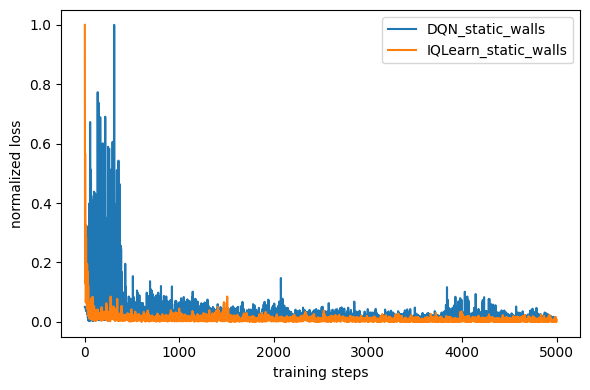

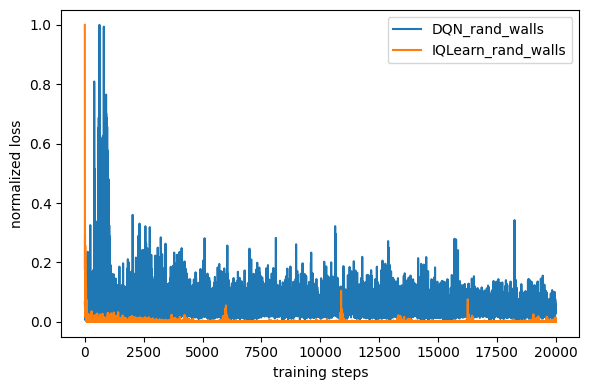

In [11]:
""" compare noramlized loss between the four models """

# load in the data
DQN_static_walls_loss = load_pickle_data("data/DQN_static_walls/DQN_losses_randwalls_False.pkl")
DQN_rand_walls_loss = load_pickle_data("data/DQN_rand_walls/DQN_losses_randwalls_True.pkl")
IQLearn_static_walls_loss = load_pickle_data("data/IQLearn_static_walls/IQLearn_losses_randwalls_False.pkl")
IQLearn_rand_walls_loss = load_pickle_data("data/IQLearn_rand_walls/IQLearn_losses_randwalls_True.pkl")


plot_losses({"DQN_static_walls":DQN_static_walls_loss,
             "IQLearn_static_walls":IQLearn_static_walls_loss},
             name="static_walls_",
             folder_path="data/")

plot_losses({"DQN_rand_walls":DQN_rand_walls_loss,
             "IQLearn_rand_walls":IQLearn_rand_walls_loss},
             name="rand_walls_",
             folder_path="data/")


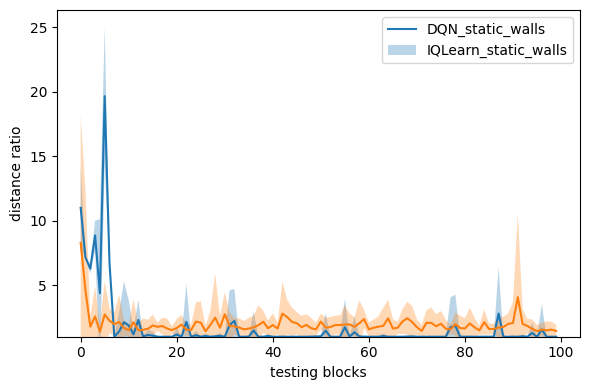

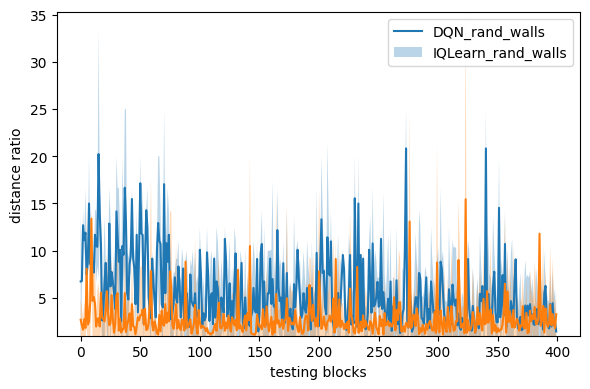

In [12]:
""" compare distance ratios between the four models """

# load in the data
DQN_static_walls_dr = load_pickle_data("data/DQN_static_walls/DQN_distance_ratios_randwalls_False.pkl")
DQN_rand_walls_dr = load_pickle_data("data/DQN_rand_walls/DQN_distance_ratios_randwalls_True.pkl")
IQLearn_static_walls_dr = load_pickle_data("data/IQLearn_static_walls/IQLearn_distance_ratios_randwalls_False.pkl")
IQLearn_rand_walls_dr = load_pickle_data("data/IQLearn_rand_walls/IQLearn_distance_ratios_randwalls_True.pkl")


plot_distance_ratios({"DQN_static_walls":DQN_static_walls_dr,
             "IQLearn_static_walls":IQLearn_static_walls_dr},
             name="static_walls_",
             folder_path="data/")

plot_distance_ratios({"DQN_rand_walls":DQN_rand_walls_dr,
             "IQLearn_rand_walls":IQLearn_rand_walls_dr},
             name="rand_walls_",
             folder_path="data/")

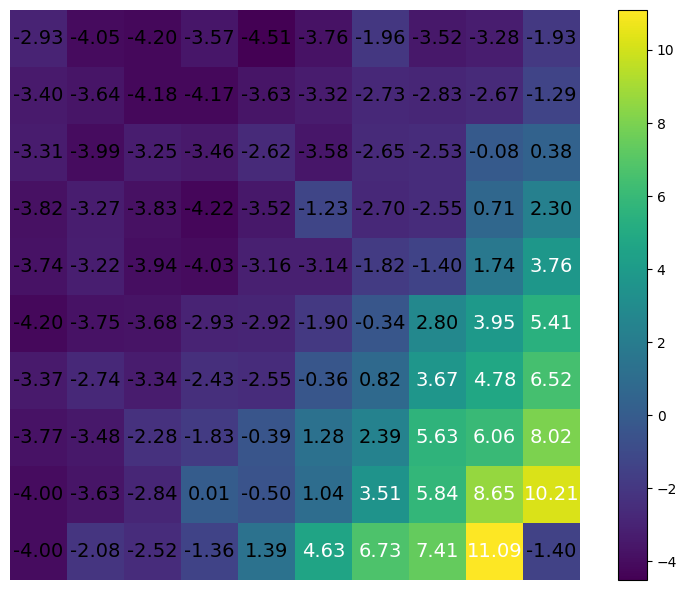

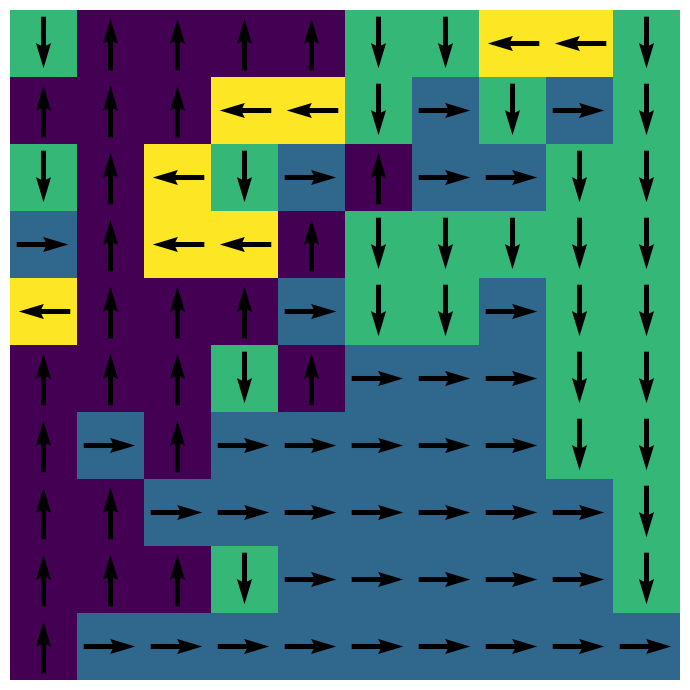

In [17]:
FOLDER_PATH = "data/DQN_rand_walls/"
MODEL_PATH = FOLDER_PATH + "DQN_rand_walls_80000_model.pt"
AGENT_TYPE = "DQN"
WALL_TYPE = 'rand'

grid = GridWorld(10,10, random_board=False,random_start=False, num_walls=0, static_start_pos = Position(0,9), max_moves_per_game=1000)
DQNModel = Model(name=AGENT_TYPE+"_"+WALL_TYPE+"_walls", model=init_grid_model(grid.num_states, grid.action_space))
DQNModel.format_state = unroll_grid
DQNModel.load(MODEL_PATH)
_, policy_map = DQNModel.estimate_value_map(grid, save=True, path=FOLDER_PATH)

DQNModel.plot_argmax_policy(policy_map, save=True, path=FOLDER_PATH)

In [ ]:
from experiments_functions import *

### load models and plot value maps
grid = GridWorld(10,10, random_board=False,random_start=False, num_walls=0, static_start_pos = Position(0,9), max_moves_per_game=1000)
DQNModel = Model(name="DQNModel", model=init_grid_model(grid.num_states, grid.action_space))
DQNModel.format_state = unroll_grid
DQNModel.load("compare_training_results/models/DQN20000model.pt")
_, policy_map = DQNModel.estimate_value_map(grid, save=True, path="compare_training_results/models/")

DQNModel.plot_argmax_policy(policy_map)

grid = GridWorld(10,10, random_board=False,random_start=False, num_walls=0, static_start_pos = Position(0,9), max_moves_per_game=1000)
IQLearnModel = Model(name="IQLearnModel", model=init_grid_model(grid.num_states, grid.action_space))
IQLearnModel.format_state = unroll_grid
IQLearnModel.load("compare_training_results/models/IQLearn20000model.pt")
_, policy_map = IQLearnModel.estimate_value_map(grid, save=True, path="compare_training_results/models/")

IQLearnModel.plot_argmax_policy(policy_map)

In [ ]:
""" plot visitation map from human expert dataset """

from experiments_functions import *
from plotting_utils import plot_state_visitation_map, plot_trajectories

trajectory_path = "expert_data/human_5000.pkl"

# set up a temporary buffer to hold the trajectory data
b = Buffer(memory_size=5000)
b.load_trajectories(trajectory_path, num_trajectories=530)

state_list = [b.data[i][0] for i in range(len(b.data))]
dones = [b.data[i][4] for i in range(len(b.data))]

plot_state_visitation_map(state_list, dones=dones, name="human_expert")

